# Convert Lat/Lon Files to Polar Stereographic Files

This notebook provides a workflow for converting lat/lon netcdf files to polar stereographic coordinates. Then, we combine the polar stereographic underlying data files and mask files in order to use as input to cgnet. To get the data into the proper format, we needed to do the following:
 - utilize a template file as a base for modifying netcdf files of the existing mask arrays. The template file includes all proper GIS attributes.
 - python script reads the Geotiff file and creates a netcdf file with the x,y,lat,lon coordinate dimensions and variables

Authors:
 - John Truesdale
 - Teagan King

Some background notes from John on methods for regridding:
----------------------------------------------------------
 - used QGIS to assign a standard stereographic coordinate and create a GeoTiff file version of one of the Polar jpg plots
 - Giving a standard location to each jpeg pixel basically consisted of finding similar features at the pixel level (the tip of an island, the most inset part of a promenent bay) between our polar jpegs and a map that is already georeferenced and has known locations for those pixels. If you choose 3-10 pixels in common you can create a linear regression that will map out all the rest of the pixels on your jpeg.
 - Once the GIS application was able to calculate the transform to go from pixel to a standard coordinate system, I saved all that information in a GeoTiff file.
 - The polar projection jpegs on which the climatenet masks are drawn were created from python matplotlib and you can grab the coordinate information from matplotlib; this was checked with QGIS
 - Because the LLNL polar jpegs are a projected coordinate, the underlying unit in a stereographic projection is meters.  The x and y variables on the GeoTiff and converted netcdf file contain meter offsets of every pixel (row,col) of the ar_mask array with respect to one of the standard south pole stereographic coordinate systems.
 -   When you look at the square projected polar image you see that the longitude lines converge at the pole and latitudes are a set of nested circles.  When you are describing this grid in lat/lon coordinates it is known as a curvilinear grid where each pixel (array location) requires a unique lat/lon pair to specify its position on a regular grid. A straight line along any row or column of the jpeg raster (or ar_mask array) will intersect different lat lon values for every pixel.  The coordinate information for our rectangular ar_mask array therefore contains lat and lon variables that are two dimensions and describe the entire grid of 1152x1152 points with unique lat/lon values for each pixel (array location) of ar_mask. The standard netcdf way of denoting a curvilinear coordinate is by creating the dimensions that define the size of the ar_mask array (x,y), adding lat/lon variables that are each dimensioned (x,y) containing the lat/lon coordinates of that point, and finally adding metadata to the ar_mask array noting that the coordinates for this variable are not the dimension variables x,y but the lat/lon variables.

Generate remapped IVT/TMQ/etc underlying data:  
 - ESMF_RegridWeightGen --ignore_unmapped --dst_regional -m bilinear -w map_fv0.23x0.31_to_sp_stereo_near.nc -s /glade/p/cesmdata/inputdata/share/scripgrids/fv0.23x0.31_141008.nc -d /glade/u/home/jet/sp_stereographic_SCRIP.nc  
 - ncremap -m ./map_fv0.23x0.31_to_sp_stereo_near.nc -i windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001-200012.nc -o polar_ivt/windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001-200012.nc  
 - see /glade/scratch/tking/cgnet/high_lat_QC/

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os
from rasterio.warp import transform
import urllib.request
import xarray as xr
import glob
from netCDF4 import date2num
from netCDF4 import Dataset
import numpy as np
import datetime as dt
import cftime

## Generate template file (only needs to be done once)

In [2]:
# # Read the data
# input_path = '/glade/work/tking/cgnet/polar_regridding/data-2003-04-29-02-0-copy-sav1.tif'

# da = xr.open_rasterio(input_path)
# yval=da['y']
# ryval=np.flip(yval)
# # Compute the lon/lat coordinates with rasterio.warp.transform
# ny, nx = len(da['y']), len(da['x'])
# x, y = np.meshgrid(da['x'], ryval)
# # Rasterio works with 1D arrays
# lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
#                      x.flatten(), y.flatten())
# lon = np.asarray(lon).reshape((ny, nx))
# lat = np.asarray(lat).reshape((ny, nx))
# da.coords['lon'] = (('y', 'x'), lon)
# da.coords['lat'] = (('y', 'x'), lat)

In [3]:
# da.to_netcdf(path='/glade/work/tking/cgnet/polar_regridding/data-2003-04-29-02-0-sav1-rev-latlon.nc')
# # use for just antarctic

## set up dask

In [4]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='25GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/$USER/local_dask', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    account='P93300313', # Input your project ID here, previously this was known as 'project', now is 'account'
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:44837,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## define dictionary of file names

In [2]:
tmq_dict = {2000: "prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100.nc",
            2001: "prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200101010000-200112312100.nc",
            2002: "prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200201010000-200212312100.nc",
            2003: "prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200301010000-200312312100.nc",
            2004: "prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200401010000-200412312100.nc"}

ivt_dict = {2000: "windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001-200012.nc",
            2001: "windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200101-200112.nc",
            2002: "windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200201-200212.nc",
            2003: "windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200301-200312.nc",
            2004: "windhusavi_3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200401-200412.nc"}

psl_dict = {2000: "psl_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100.nc",
            2001: "psl_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200101010000-200112312100.nc",
            2002: "psl_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200201010000-200212312100.nc",
            2003: "psl_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200301010000-200312312100.nc",
            2004: "psl_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200401010000-200412312100.nc"}

pr_dict = {2000: "pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312359.nc",
           2001: "pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200101010000-200112312359.nc",
           2002: "pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200201010000-200212312359.nc",
           2003: "pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200301010000-200312312359.nc",
           2004: "pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200401010000-200412312359.nc",
           2005: "pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200501010000-200512052359.nc"}

## Change to 2-dimensional lat/lon before regridding 

## Regrid

In [7]:
# TODO: These files don't exist anymore. Would possibly need to bring back over...
# But I think we can used the processed data and not have to re-do this step

for var in ['pr']:
    if var=='pr':
        dictionary = pr_dict
    elif var=='psl':
        dictionary = psl_dict
    elif var=='ivt':
        dictionary = ivt_dict
    for year in [2000]: #,2001,2002,2003,2004]:
        ds_before_regrid = xr.open_dataset('/glade/scratch/tking/cgnet/high_lat_QC/{}/{}'.format(var, dictionary[year]))
        ds_before_regrid
        # we want this to be two dimensional lat/lon instead of 1

        # mesh is one useful tool but could do by hand
        # duplicate lat/lon array for lon/lat number of times
        # in order to have lat (y,x) and lon (y,x)

        # y is lat
        # x is lon
        # dimensions should be time, x, y, 
        # follow example here: https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html
        y_len = ds_before_regrid.lon.shape[0]
        x_len = ds_before_regrid.lat.shape[0]

        ds_before_regrid['lat_val'] = (('y','x'), np.tile(ds_before_regrid.lat, (y_len,1)))
        ds_before_regrid['lon_val'] = (('y','x'), np.transpose(np.tile(ds_before_regrid.lon, (x_len,1))))

        # ds_before_regrid.to_netcdf('/glade/scratch/tking/cgnet/high_lat_QC/{}/2dlatlon/{}'.format(var,dictionary[year]))
        # print('generated {}'.format(dictionary[year]))

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/tking/cgnet/high_lat_QC/pr/pr_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312359.nc'

In [21]:
# ds_before_regrid

# MissingDimensionsError: 'lat' has more than 1-dimension and the same name as one of
# its dimensions ('lat', 'lon'). xarray disallows such variables because they conflict
# with the coordinates used to label dimensions.

In [19]:
ds_before_regrid['pr'] = ds_before_regrid.pr.swap_dims({'lat':'x','lon':'y'})

In [20]:
ds_before_regrid

<xarray.Dataset>
Dimensions:    (height: 1, lat: 768, lon: 1152, time: 2920, nb2: 2, x: 768,
                y: 1152)
Coordinates:
  * height     (height) float32 0.0
  * lat        (lat) float32 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float32 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time       (time) object 2000-01-01 01:30:00 ... 2000-12-31 22:30:00
Dimensions without coordinates: nb2, x, y
Data variables:
    time_bnds  (time, nb2) object ...
    pr         (time, height, x, y) float32 ...
    lat_val    (y, x) float32 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
    lon_val    (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 359.7 359.7 359.7 359.7
Attributes: (12/22)
    history:                   2017-03-03T13:07:25Z: Naming and attribute con...
    forcing:                   SST=sst_HadOIBl_bc_0.23x0.31_1870_2008_c091020...
    institute_run_id:          cam5_1_amip_run2
    CDO:                       Climate Data Operators version 1.6.5.2 (http:/...
    institution:               Lawrence Berkeley National Laboratory, Berkele...
    institute_id:              LBNL
    ...                        ...
    parent_experiment:         N/A
    parent_subexperiment:      N/A
    parent_run_id:             N/A
    project_id:                C20C+ Detection and Attribution Project
    license:                   Creative Commons License: http://creativecommo...
    creation_date:             2017-03-03T13:07:25Z

In [28]:
ds_before_regrid = ds_before_regrid.drop_dims('lat')
ds_before_regrid = ds_before_regrid.drop_dims('lon')
ds_before_regrid

<xarray.Dataset>
Dimensions:    (height: 1, time: 2920, nb2: 2, x: 768, y: 1152)
Coordinates:
  * height     (height) float32 0.0
  * time       (time) object 2000-01-01 01:30:00 ... 2000-12-31 22:30:00
Dimensions without coordinates: nb2, x, y
Data variables:
    time_bnds  (time, nb2) object ...
    pr         (time, height, x, y) float32 ...
    lat_val    (y, x) float32 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
    lon_val    (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 359.7 359.7 359.7 359.7
Attributes: (12/22)
    history:                   2017-03-03T13:07:25Z: Naming and attribute con...
    forcing:                   SST=sst_HadOIBl_bc_0.23x0.31_1870_2008_c091020...
    institute_run_id:          cam5_1_amip_run2
    CDO:                       Climate Data Operators version 1.6.5.2 (http:/...
    institution:               Lawrence Berkeley National Laboratory, Berkele...
    institute_id:              LBNL
    ...                        ...
    parent_experiment:         N/A
    parent_subexperiment:      N/A
    parent_run_id:             N/A
    project_id:                C20C+ Detection and Attribution Project
    license:                   Creative Commons License: http://creativecommo...
    creation_date:             2017-03-03T13:07:25Z

In [29]:
ds_before_regrid.to_netcdf('/glade/scratch/tking/cgnet/high_lat_QC/{}/2dlatlon/{}'.format(var,dictionary[year]))

## regrid TMQ/IVT/PSL/PR data from lat/lon to polar

In [3]:
# submit scripts below in batch scripts, see example at
#     /glade/scratch/tking/cgnet/high_lat_QC/from_nersc/2dlatlon/remap_script and batch_remap.sh

In [314]:
# module load gnu/9.1.0
# module load esmf_libs/8.0.0
# module load esmf-8.0.0-ncdfio-mpi-O
# module load nco/4.7.9

In [315]:
# set srcgrid=f09
# set dstgrid=sp_stereo
# set srcgridfile=/glade/p/cesmdata/inputdata/share/scripgrids/fv0.23x0.31_141008.nc
# set dstgridfile=/glade/u/home/jet/sp_stereographic_SCRIP.nc
# set srcinitfile=prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100.nc
# set dstinitfile=polar_tmq/prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100_polar_nearest.nc

# #create the map file
# ESMF_RegridWeightGen --ignore_unmapped --src_regional -m neareststod -w map_${srcgrid}_to_${dstgrid}_near.nc -s ${srcgridfile} -d ${dstgridfile}

# #use the mapfile to remap srcinitfile to dstinitfile
# ncremap -m ./map_${srcgrid}_to_${dstgrid}_near.nc -i ${srcinitfile} -o ${dstinitfile}

## Rename regridded files to avoid lat/lon being dimension and variable name

In [4]:
# use ncrename to rename the output lat/lon dims to not conflict with vars
# ncrename -v lon,longitude -d lat,latitude prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100.nc renamed/prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100.nc

pr_ds = xr.open_dataset('/glade/scratch/tking/cgnet/high_lat_QC/prw/2dlatlon/polar_tmq/renamed/renamed_2/prw_A3hr_CAM5-1-025degree_All-Hist_est1_v1-0_run002_200001010000-200012312100.nc')


In [5]:
pr_ds

<xarray.Dataset>
Dimensions:    (latitude: 1152, longitude: 1152, nvertices: 4, time: 2919,
                nbnd: 2)
Coordinates:
  * time       (time) object 2000-01-01 03:00:00 ... 2000-12-31 21:00:00
Dimensions without coordinates: latitude, longitude, nvertices, nbnd
Data variables:
    lat        (latitude, longitude) float64 ...
    lon        (latitude, longitude) float64 ...
    area       (latitude, longitude) float64 ...
    lat_bnds   (latitude, longitude, nvertices) float64 ...
    lon_bnds   (latitude, longitude, nvertices) float64 ...
    prw        (time, latitude, longitude) float32 ...
    time_bnds  (time, nbnd) object ...
Attributes: (12/28)
    forcing:                   SST=sst_HadOIBl_bc_0.23x0.31_1870_2008_c091020...
    institute_run_id:          cam5_1_amip_run2
    institution:               Lawrence Berkeley National Laboratory, Berkele...
    institute_id:              LBNL
    experiment_family:         All-Hist
    experiment:                est1
    ...                        ...
    remap_hostname:            crhtc04
    remap_version:             4.7.9
    NCO:                       netCDF Operators version 5.0.3 (Homepage = htt...
    map_file:                  ../../map_fv0.23x0.31_to_sp_stereo_near.nc
    input_file:                /glade/scratch/tking/cgnet/high_lat_QC/prw/2dl...
    history:                   Mon Mar 27 11:34:43 2023: ncrename -d lat,lati...

## Generate combined mask/underlying data files by creating netcdf from scratch

### run this next cell if temp.nc already exists

In [26]:
rm /glade/u/home/tking/work/cgnet/QA_xml/all_antarctic_converted_masks/temp.nc

### Note on time adjustment
We'll need to use the bug fix included in the below cells for the first two rounds of QC'd data; this issue has been fixed in the masks of following datasets

### Create temp file with correct attributes

In [28]:
temp_file = '/glade/work/tking/cgnet/polar_regridding/data-2003-04-29-02-0-sav1-rev-latlon.nc'
temp = xr.open_dataset(temp_file)

ncfile = Dataset('/glade/u/home/tking/work/cgnet/QA_xml/all_antarctic_converted_masks/temp.nc',mode='w',format='NETCDF4_CLASSIC') 

# lat_dim = ncfile.createDimension('lat', 1152)     # latitude axis
# lon_dim = ncfile.createDimension('lon', 1152)    # longitude axis
y_dim = ncfile.createDimension('y', 1152)        # latitude axis
x_dim = ncfile.createDimension('x', 1152)        # longitude axis
time_dim = ncfile.createDimension('time', None)  # unlimited axis (can be appended to)
# time_index_dim = ncfile.createDimension('time_index', 350)
sample_id_dim = ncfile.createDimension('sample_id', 4)

# include time variable and relevant attributes
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'hours since 1970-01-01'
time.calendar = 'noleap'
time.long_name = 'time'

date = ncfile.createVariable('date', np.float64, ('time',))
date.long_name = 'current date (YYYYMMDD)'
datesec = ncfile.createVariable('datesec', np.float64, ('time',))
date.long_name = 'current seconds of current date'

# include ar_mask variable and relevant attributes
ar_mask = ncfile.createVariable('ar_mask', np.float64, ('time','sample_id','y','x'))
ar_mask.units = 'hours since 1970-01-01'
ar_mask.calendar = 'noleap'
ar_mask.long_name = 'time'

# include underlying data
tmq = ncfile.createVariable('tmq',np.float64,('time','sample_id','y','x'))
ivt = ncfile.createVariable('ivt',np.float64,('time','sample_id','y','x'))
psl = ncfile.createVariable('psl',np.float64,('time','sample_id','y','x'))
pr = ncfile.createVariable('pr',np.float64,('time','sample_id','y','x'))

y = ncfile.createVariable('y',np.float64,('y'))
x = ncfile.createVariable('x',np.float64,('x'))
lat = ncfile.createVariable('lat',np.float64,('y','x'))
lon = ncfile.createVariable('lon',np.float64,('y','x'))

y = temp.y
x = temp.x
lat = temp.lat
lon = temp.lon

# copy temp file x, y, lat, lon values into x, y lat, lon
ivt.transform = temp.__xarray_dataarray_variable__.transform
ivt.crs = temp.__xarray_dataarray_variable__.crs
ivt.coordinates = 'lat lon'
tmq.coordiantes = 'lat lon'
psl.coordiantes = 'lat lon'
pr.coordiantes = 'lat lon'

# assign_attrs({'transform' : temp.__xarray_dataarray_variable__.transform,
#                   'crs': temp.__xarray_dataarray_variable__.crs,
#                   'res': temp.__xarray_dataarray_variable__.res,
#                   'is_tiled': temp.__xarray_dataarray_variable__.is_tiled,
#                   'nodatavals': temp.__xarray_dataarray_variable__.nodatavals,
#                   'scales': temp.__xarray_dataarray_variable__.scales,
#                   'offsets': temp.__xarray_dataarray_variable__.offsets,
#                   'AREA_OR_POINT': temp.__xarray_dataarray_variable__.AREA_OR_POINT,
#                   "coordinates": "lat lon"})

# psl['psl'].assign_attrs({'transform' : temp.__xarray_dataarray_variable__.transform,
#                   'crs': temp.__xarray_dataarray_variable__.crs,
#                   'res': temp.__xarray_dataarray_variable__.res,
#                   'is_tiled': temp.__xarray_dataarray_variable__.is_tiled,
#                   'nodatavals': temp.__xarray_dataarray_variable__.nodatavals,
#                   'scales': temp.__xarray_dataarray_variable__.scales,
#                   'offsets': temp.__xarray_dataarray_variable__.offsets,
#                   'AREA_OR_POINT': temp.__xarray_dataarray_variable__.AREA_OR_POINT,
#                   "coordinates": "lat lon"})

# tmq['tmq'].assign_attrs({'transform' : temp.__xarray_dataarray_variable__.transform,
#                   'crs': temp.__xarray_dataarray_variable__.crs,
#                   'res': temp.__xarray_dataarray_variable__.res,
#                   'is_tiled': temp.__xarray_dataarray_variable__.is_tiled,
#                   'nodatavals': temp.__xarray_dataarray_variable__.nodatavals,
#                   'scales': temp.__xarray_dataarray_variable__.scales,
#                   'offsets': temp.__xarray_dataarray_variable__.offsets,
#                   'AREA_OR_POINT': temp.__xarray_dataarray_variable__.AREA_OR_POINT,
#                   "coordinates": "lat lon"})

# pr['pr'].assign_attrs({'transform' : temp.__xarray_dataarray_variable__.transform,
#                   'crs': temp.__xarray_dataarray_variable__.crs,
#                   'res': temp.__xarray_dataarray_variable__.res,
#                   'is_tiled': temp.__xarray_dataarray_variable__.is_tiled,
#                   'nodatavals': temp.__xarray_dataarray_variable__.nodatavals,
#                   'scales': temp.__xarray_dataarray_variable__.scales,
#                   'offsets': temp.__xarray_dataarray_variable__.offsets,
#                   'AREA_OR_POINT': temp.__xarray_dataarray_variable__.AREA_OR_POINT,
#                   "coordinates": "lat lon"})
     

### Loop through mask files and underlying data files; add both to temp file

In [29]:
time_index = -1
for year in [2002]: # 2002, 2003 # THESE CORRESPOND TO MASK'S LISTED (INCORRECT) YEARS
    mask_file_list = sorted(glob.glob('/glade/u/home/tking/work/cgnet/QA_xml/h5/qa*/antarctic/netcdfs/data-{}-*'.format(year)))
    
    # TODO: figure out how to run last few dates in year separately?
    shifted_year = year - 1
    
    # BUG FIX FROM 2000 DATA BEING PULLED IN PREVIOUSLY:
    shifted_year = 2000

    # tmq_ds = xr.open_dataset('/glade/scratch/tking/cgnet/high_lat_QC/prw/2dlatlon/polar_tmq/renamed/{}'.format(tmq_dict[shifted_year]))
    # lat: 768 lon: 1152 time: 2919 nbnd: 2
    # psl_ds = xr.open_dataset('/glade/scratch/tking/cgnet/high_lat_QC/psl/2dlatlon/polar_psl/renamed/{}'.format(psl_dict[shifted_year]))
    # lat: 768 lon: 1152 time: 2919 nbnd: 2
    ivt_ds = xr.open_dataset('/glade/scratch/tking/cgnet/high_lat_QC/ivt/2dlatlon/polar_ivt/renamed/{}'.format(ivt_dict[shifted_year]))
    # time: 2920 bound: 2 lat: 768 lon: 1152
    # pr_ds = xr.open_dataset('/glade/scratch/tking/cgnet/high_lat_QC/pr/2dlatlon/polar_pr/renamed/{}'.format(pr_dict[shifted_year]))
    # height: 1 lat: 768 lon: 1152 time: 2920 nb2: 2
    
    for antarctic_mask_file in mask_file_list[:]:

        time = antarctic_mask_file.split('/')[-1].split('data-')[1].split('.nc')[0].split('-00-2')[0]
        time_year = int(time.split('-')[0])  # or = year
        
        # TODO: bug fix! Assume that the nc file is ~named~ 2001, and underlying data is 2000. (For all labeled years, 2000 data was used...)
        time_year = 2001
        
        time_month = int(time.split('-')[1])
        time_day = int(time.split('-')[2])
        time_hour = 0  # all files were 00
        date_number = date2num(dt.datetime(time_year, time_month, time_day, time_hour, 0), 'hours since 1970-01-01')
        
        print("time before fixing: ", time_year, time_month, time_day)

        # ---------------------------------------------------------------------------------
        # FIX FOR INDEXING BUGS IS NOW IN ALL_CHEY_ARCTIC.IPYNB and ALL_CHEY_ANTARCTIC.IPYNB.
        # If 2000, adjust days by 4, otherwise, adjust days by 5 (to account for leap days)
        if time_year == 2000:
            leap_year_adjustment = 4
        if time_year >= 2001:
            leap_year_adjustment = 5
        if time_month in [1, 3, 5, 7, 8, 10, 12]: # months with 31 days
            days_in_month = 31
            # adjust year for indexing issue unless last few days in file (because of leap year, these got included in correct file)
            if time_month == 12 and time_day < (days_in_month - leap_year_adjustment):
                time_year = time_year - 1
            else:
                time_year = time_year - 1
            if time_day < (days_in_month - leap_year_adjustment):
                time_day = time_day + leap_year_adjustment
            else:
                time_day = ((time_day + leap_year_adjustment) - days_in_month) + 1 # add 4 days for leap year, subtract days in month, add 1 because month starts at 1 not 0.
                time_month += 1 # use one of the first few days in the next month
                if time_month == 13:  # no 13th month, so loop back to January
                    time_month = 1
        elif time_month in [4, 6, 9, 11]: # months with 30 days
            time_year = time_year - 1
            days_in_month = 30
            if time_day < (days_in_month - leap_year_adjustment):
                time_day = time_day + leap_year_adjustment
            else:
                time_day = ((time_day + leap_year_adjustment) - days_in_month) + 1
                time_month += 1 # use one of the first few days in the next month
        elif time_month == 2:
            time_year = time_year - 1
            days_in_month = 28
            if time_day < (days_in_month - leap_year_adjustment):
                time_day = time_day + leap_year_adjustment
            else:
                time_day = ((time_day + leap_year_adjustment) - days_in_month) + 1
                time_month += 1 # use one of the first few days in the next month

        print("time after fixing: ", time_year, time_month, time_day)
        # ---------------------------------------------------------------------------------

        if time_month < 10:
            time_m_formatted = '0'+str(time_month)
        else:
            time_m_formatted = str(time_month)
        if time_day < 10:
            time_d_formatted = '0'+str(time_day)
        else:
            time_d_formatted = str(time_day)

        if antarctic_mask_file[-3:-2] == '_':
            sample_id = int(antarctic_mask_file[-4:-3])
        else:
            sample_id = 0
        # TODO: for some reason, the 2002 files seem to sometimes start at _0 and sometimes just end with -2 and if repeat date, include _1.nc
        # Above is a bug fix for that, but we should ensure the workflow that generated this issue gets fixed
        if sample_id == 0:
            time_index+=1

        if time_index == 10:
            print('PROBLEM INDEX BELOW:')
        print('sample id: {}'.format(sample_id))
        print('time_index: {}'.format(time_index))
        
        
        qa_aa_ds = xr.open_dataset(antarctic_mask_file)
        # qa_aa_ds = qa_aa_ds.transpose('phony_dim_0', 'phony_dim_1')  # TODO: comment out?
        # qa_aa_ds['ar_masks'] = qa_aa_ds.ar_masks.transpose(transpose_coords=True)
        # qa_aa_ds = qa_aa_ds.isel(phony_dim_0=slice(None, None, -1))
        
        # reorientation needed for viewing with matplotlib - TODO: maybe will need to comment out once using netcdf?
        qa_aa_ds.ar_masks['phony_dim_0'] = qa_aa_ds.ar_masks['phony_dim_0'][::-1]
        qa_aa_ds.reindex(phony_dim_0=list(reversed(qa_aa_ds.phony_dim_0)))
        
        # fill in date and datesec
        date[:] = str(time_year)+time_m_formatted+time_d_formatted
        datesec[:] = '00'

        # fill in ar_mask
        ar_mask[time_index,sample_id,:,:]=qa_aa_ds.ar_masks
        
        if time_index == 10:
            print(ar_mask)
            print(ar_mask.vars)
            print(ar_mask.time_index)
            print(ar_mask.sample_id)
            print(qa_aa_ds)

        # pr[time_index,sample_id,:,:] = pr_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 22, 30, 0, 0, has_year_zero=True), method='nearest').pr.rename({'latitude': 'lat', 'longitude': 'lon'}).isel(height=0)
        # psl[time_index,sample_id,:,:] = psl_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 22, 30, 0, 0, has_year_zero=True), method='nearest').psl.rename({'latitude': 'lat', 'longitude': 'lon'})
        # tmq[time_index,sample_id,:,:] = tmq_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 22, 30, 0, 0, has_year_zero=True), method='nearest').prw.rename({'latitude': 'lat', 'longitude': 'lon'})
        ivt[time_index,sample_id,:,:] = ivt_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 22, 30, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'})

        
        if time_index == 10:  # TODO: maybe try breaking at a lower point instead and see what's different?
            break
    # ncfile.to_netcdf()
    # todo: write netcdf here
    # TODO: need to fix timestamp on each mask/underlying data pair

['/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-01-09-00-2_0.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-01-10-00-2_0.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-01-30-00-2_0.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-02-07-00-2_0.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-02-17-00-2_0.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-02-22-00-2_0.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa1/antarctic/netcdfs/data-2002-02-22-00-2_1.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa2/antarctic/netcdfs/data-2002-03-25-00-2.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa2/antarctic/netcdfs/data-2002-04-02-00-2.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa2/antarctic/netcdfs/data-2002-04-02-00-2_1.nc', '/glade/u/home/tking/work/cgnet/QA_xml/h5/qa2/antarctic/netcdfs/data-2002-04-04-00-

AttributeError: NetCDF: Attribute not found

In [37]:
ar_mask.__dict__

{'units': 'hours since 1970-01-01', 'calendar': 'noleap', 'long_name': 'time'}

In [38]:
ar_mask

<class 'netCDF4._netCDF4.Variable'>
float64 ar_mask(time, sample_id, y, x)
    units: hours since 1970-01-01
    calendar: noleap
    long_name: time
unlimited dimensions: time
current shape = (11, 4, 1152, 1152)
filling on, default _FillValue of 9.969209968386869e+36 used

In [39]:
qa_aa_ds

<xarray.Dataset>
Dimensions:   (phony_dim_0: 1152, phony_dim_1: 1152)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    ar_masks  (phony_dim_0, phony_dim_1) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    projection:  South Pole Stereographic, bounding lat = 20S
    history:     Fri Feb 24 16:20:59 2023: ncatted -O -a projection,global,c,...
    NCO:         netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net...

In [50]:
ncfile.dimensions

{'y': <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1152,
 'x': <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1152,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 11,
 'sample_id': <class 'netCDF4._netCDF4.Dimension'>: name = 'sample_id', size = 4}

In [53]:
ivt

<class 'netCDF4._netCDF4.Variable'>
float64 ivt(time, sample_id, y, x)
    transform: [   15466.39379236        0.         -8909791.5393            0.
   -15493.26849931  8913206.2037    ]
    crs: +proj=stere +lat_0=-90 +lat_ts=-90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True
    coordinates: lat lon
unlimited dimensions: time
current shape = (11, 4, 1152, 1152)
filling on, default _FillValue of 9.969209968386869e+36 used

In [ ]:
ncfile.close()

In [318]:
# view the data in polar format:
# ncks -v pr -d sample_id,1 -d time,1 temp.nc out.nc
# ncks -d sample_id,1 -d time,1 temp.nc out.nc

## Check for alignment of underlying data and masks. These are some options for rotations/transposing/etc

In [327]:
# Need to flip image because currently flipped vertically compared to netcdf view
# qa_aa_ds = qa_aa_ds.isel(phony_dim_0=slice(None, None, -1))
# We want to flip values within phony_dim_0
qa_aa_ds.ar_masks['phony_dim_0'] = qa_aa_ds.ar_masks['phony_dim_0'][::-1]
qa_aa_ds.reindex(phony_dim_0=list(reversed(qa_aa_ds.phony_dim_0)))

<xarray.Dataset>
Dimensions:      (phony_dim_0: 1152, phony_dim_1: 1152)
Coordinates:
  * phony_dim_0  (phony_dim_0) int64 1151 1150 1149 1148 1147 1146 ... 4 3 2 1 0
Dimensions without coordinates: phony_dim_1
Data variables:
    ar_masks     (phony_dim_0, phony_dim_1) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    projection:  South Pole Stereographic, bounding lat = 20S
    history:     Fri Feb 24 16:19:19 2023: ncatted -O -a projection,global,c,...
    NCO:         netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net...

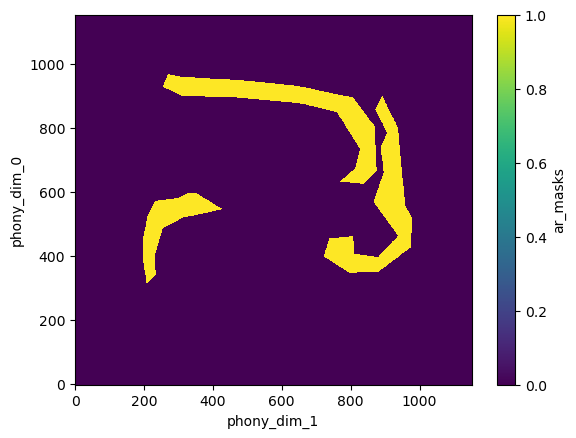

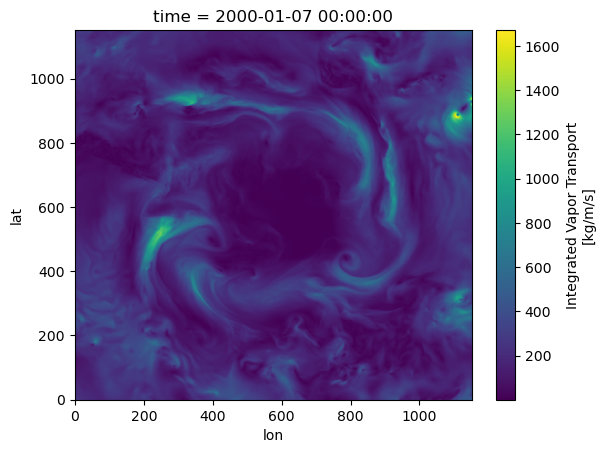

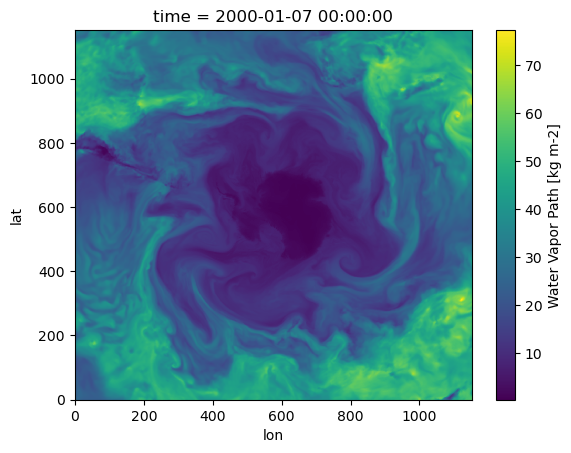

In [323]:
# plot mask
qa_aa_ds.ar_masks.plot()
plt.show()

# timestamp that matches!
ivt_ds.sel(time=cftime.DatetimeNoLeap(2000, 1, 6, 22, 30, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
plt.show()

tmq_ds.sel(time=cftime.DatetimeNoLeap(2000, 1, 6, 22, 30, 0, 0, has_year_zero=True), method='nearest').prw.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
plt.show()

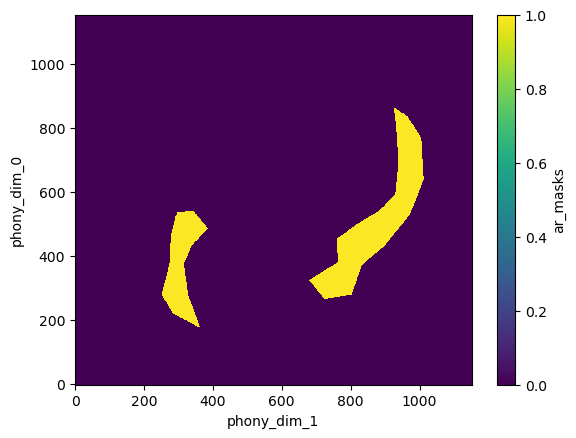

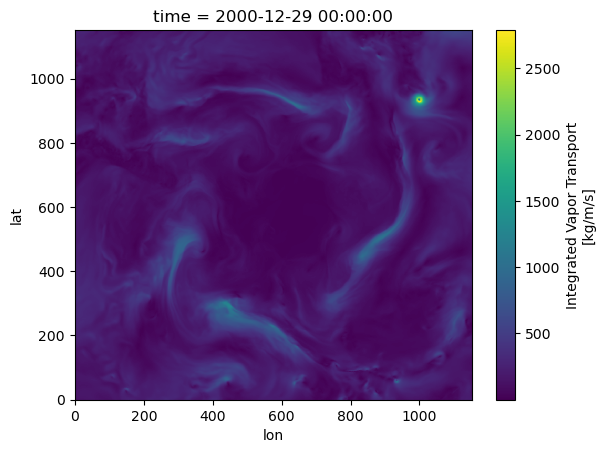

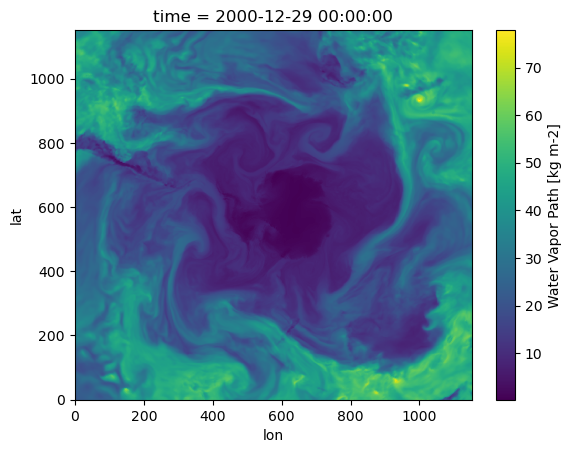

In [328]:
# ANOTHER EXAMPLE
qa_aa_ds.ar_masks.plot()
plt.show()

# 1 year earlier, 12/28 22:30 == data-2001-12-23-00-2_0.nc

ivt_ds.sel(time=cftime.DatetimeNoLeap(2000, 12, 28, 22, 30, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
plt.show()

tmq_ds.sel(time=cftime.DatetimeNoLeap(2000, 12, 28, 22, 30, 0, 0, has_year_zero=True), method='nearest').prw.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
plt.show()

In [ ]:
# ANOTHER EXAMPLE - SLIGHTLY LESS CLEAR BUT I THINK OKAY

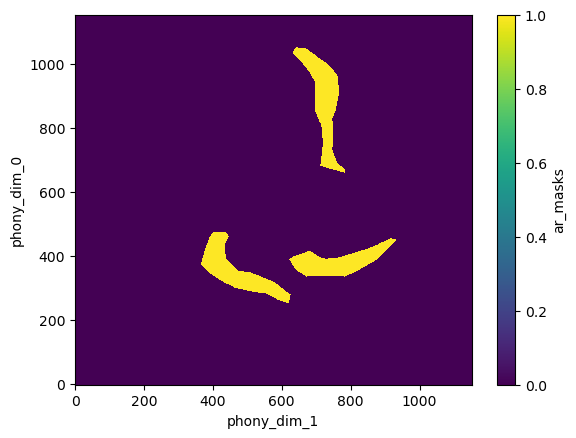

In [304]:
qa_aa_ds.ar_masks.plot()

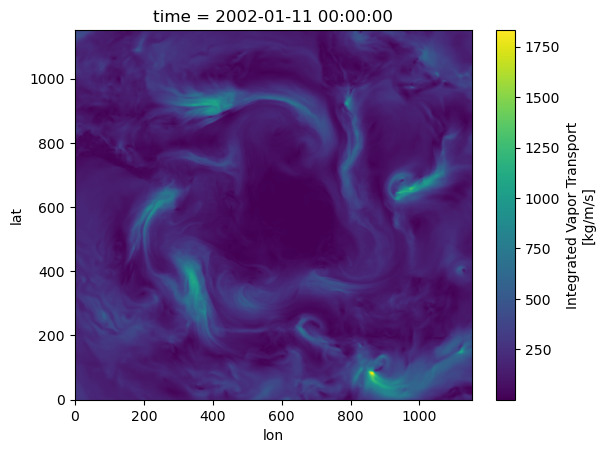

In [306]:
ivt_ds.sel(time=cftime.DatetimeNoLeap(2002, 1, 10, 22, 30, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
plt.show()

# tmq_ds.sel(time=cftime.DatetimeNoLeap(2001, 1, 10, 22, 30, 0, 0, has_year_zero=True), method='nearest').prw.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
# plt.show()

In [329]:
# ivt_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 3, 0, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
# plt.show()
# print(time_year, time_month, time_day)

# ivt_ds.sel(time=cftime.DatetimeNoLeap(2000, 12, 27, 0, 0, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
# plt.show()

# ivt_ds.sel(time=cftime.DatetimeNoLeap(2000, 12, 18, 0, 0, 0, 0, has_year_zero=True), method='nearest').windhusavi.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()
# plt.show()

In [92]:
# pr_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 3, 0, 0, 0, has_year_zero=True), method='nearest').pr.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()

In [93]:
# psl_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 3, 0, 0, 0, has_year_zero=True), method='nearest').psl.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()

In [330]:
# tmq_ds.sel(time=cftime.DatetimeNoLeap(time_year, time_month, time_day, 3, 0, 0, 0, has_year_zero=True), method='nearest').prw.rename({'latitude': 'lat', 'longitude': 'lon'}).plot()

# PART 2:

### use the standard ESMF mapping procedure to go from the projected stereographic polar mask grids to our regular gridded data from CESM. Use Steve's python code and John's mapping file commands to do this

In [35]:
# We want to do this to get masks and state information on two different grids
# need new mapping file to do this, then run through Steve's routine

In [ ]:
# Steve Yeager has a utility function for remapping CAM-SE output (see remap_camse function below):
#     https://github.com/sgyeager/mypyutils/blob/main/mypyutils/regrid_utils.py

import xarray as xr
import numpy as np
import scipy.sparse as sps
import cf_xarray

def remap_camse(ds, dsw, varlst=[]):
    #dso = xr.full_like(ds.drop_dims('ncol'), np.nan)
    dso = ds.drop_dims('ncol').copy()
    lonb = dsw.xc_b.values.reshape([dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values])
    latb = dsw.yc_b.values.reshape([dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values])
    weights = sps.coo_matrix((dsw.S, (dsw.row-1, dsw.col-1)), shape=[dsw.dims['n_b'], dsw.dims['n_a']])
    if not varlst:
        for varname in list(ds):
            if 'ncol' in(ds[varname].dims):
                varlst.append(varname)
        if 'lon' in varlst: varlst.remove('lon')
        if 'lat' in varlst: varlst.remove('lat')
        if 'area' in varlst: varlst.remove('area')
    for varname in varlst:
        shape = ds[varname].shape
        invar_flat = ds[varname].values.reshape(-1, shape[-1])
        remapped_flat = weights.dot(invar_flat.T).T
        remapped = remapped_flat.reshape([*shape[0:-1], dsw.dst_grid_dims[1].values,
                                          dsw.dst_grid_dims[0].values])
        dimlst = list(ds[varname].dims[0:-1])
        dims={}
        coords={}
        for it in dimlst:
            dims[it] = dso.dims[it]
            coords[it] = dso.coords[it]
        dims['lat'] = int(dsw.dst_grid_dims[1])
        dims['lon'] = int(dsw.dst_grid_dims[0])
        coords['lat'] = latb[:,0]
        coords['lon'] = lonb[0,:]
        remapped = xr.DataArray(remapped, coords=coords, dims=dims, attrs=ds[varname].attrs)
        dso = xr.merge([dso, remapped.to_dataset(name=varname)])
    return dso

In [ ]:
# Here is a notebook demonstrating how this is used:
#     /glade/u/home/yeager/analysis/python/toshare/CLM_field_regrid.ipynb